# Updated Finsler Fire Spread Model (Deterministic, Time‑Aware)

Compatible with the **new deterministic Finsler model** (`fire_model/finsler.py`).

This notebook demonstrates:
- Environment setup (fuel, value, wind, ROS)
- Deterministic Finsler arrival-time evolution
- Retardant drops and **retardant half‑life decay**
- Fire boundary extraction (isochrone boundary)
- A fully working **Bayesian Optimisation** loop for choosing a retardant drop (deterministic objective)


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from fire_model.ca import FireEnv
from fire_model.finsler import FinslerFireModel


## 1. Environment

We build a spatially varying **fuel** and **value** map, plus a wind field. Retardant parameters include a **half‑life** (seconds).

In [2]:
# Grid / domain
nx = ny = 90
domain_km = 2.7

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 60.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.32                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)
drop_w_km = 0.18
drop_h_km = 0.9
drop_amount = 2.0

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))

# Wind: either constant (nx,ny,2) OR time varying (T,nx,ny,2).
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 3.5
wind[..., 1] = 0.5 + 0.8 * xs[:, 0][:, None]

# Simple slope field: gentle ridge along +x with downhill toward +y
slope = np.zeros((nx, ny, 2), dtype=float)
slope[..., 0] = 0.3 * xs  # slope component aligned with x
slope[..., 1] = -0.15 * ys  # downhill when y increases

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    drop_w_km=drop_w_km,
    drop_h_km=drop_h_km,
    drop_amount=drop_amount,
    ros_mps=ros_mps,
    slope=slope,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
)


## 2. Model + plotting helpers

In [3]:
finsler = FinslerFireModel(env, diag=True, k_wind=0.45, w_ref=5.0, k_slope=0.35)

def plot_field(field2d, title, cmap=None):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(field2d.T, origin="lower", aspect="equal", cmap=cmap)
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel("x cell")
    plt.ylabel("y cell")
    plt.tight_layout()
    plt.show()

def plot_firestate(state, kind="affected", title=None):
    if kind == "burning":
        field = state.burning[0]
    elif kind == "burned":
        field = state.burned[0]
    elif kind == "affected":
        field = (state.burning[0] > 0.5) | (state.burned[0] > 0.5)
        field = field.astype(float)
    elif kind == "retardant":
        field = state.retardant[0]
    elif kind == "burn_remaining_s":
        field = state.burn_remaining_s[0]
    else:
        raise ValueError("kind must be one of: burning, burned, affected, retardant, burn_remaining_s")
    plot_field(field, title or f"{kind}")


## 3. Baseline evolution (no retardant)

We ignite a small circular patch, evolve to a **drop time**, then evolve forward to a later evaluation time.

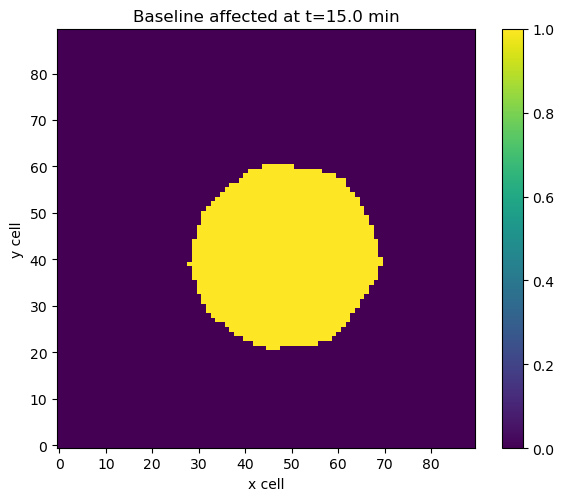

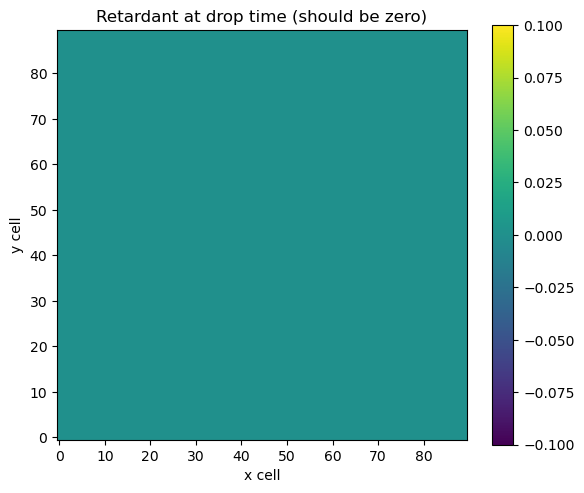

In [4]:
ignition_center = (nx // 2, ny // 2 - 6)
ignition_radius_km = 0.2

drop_time_s = 15 * 60      # when a drop would occur (seconds after ignition)
eval_horizon_s = 45 * 60   # evaluation horizon after drop_time_s

# State at drop time (no retardant)
init_state = finsler.simulate_from_ignition(
    T=drop_time_s,
    center=ignition_center,
    radius_km=ignition_radius_km,
    drone_params=None,
    start_time_s=0.0,
)

plot_firestate(init_state, kind="affected", title=f"Baseline affected at t={drop_time_s/60:.1f} min")
plot_firestate(init_state, kind="retardant", title="Retardant at drop time (should be zero)")


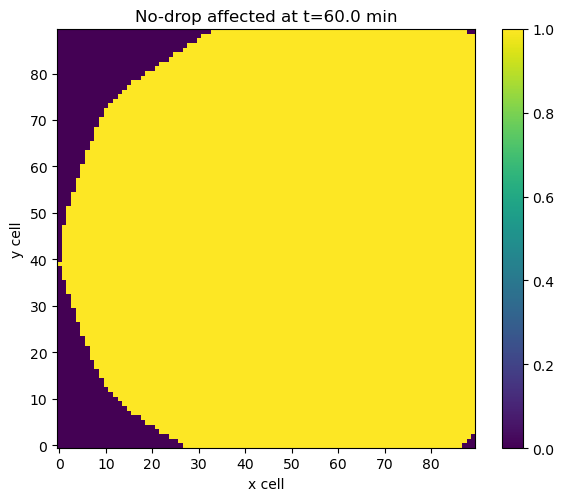

In [5]:
state_no_drop = finsler.simulate_from_firestate(
    init_state,
    T=eval_horizon_s,
    drone_params=None,
)

plot_firestate(state_no_drop, kind="affected", title=f"No-drop affected at t={(drop_time_s+eval_horizon_s)/60:.1f} min")


## 4. Retardant drop + half-life decay

We apply a single rectangular drop and inspect:
- fire evolution impact
- retardant field decay over time


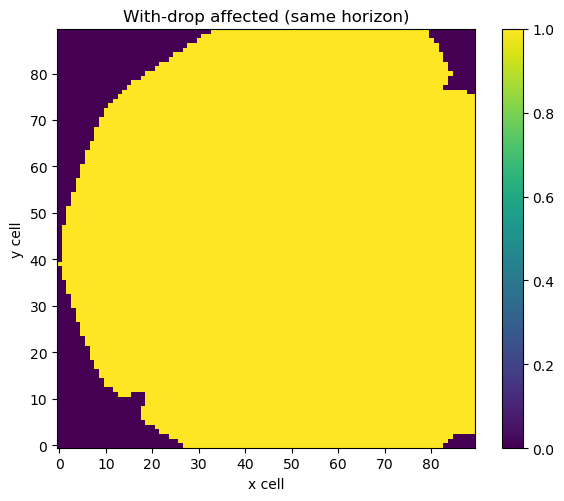

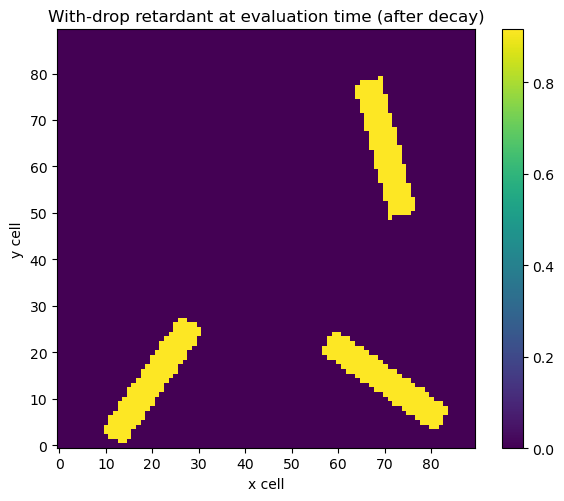

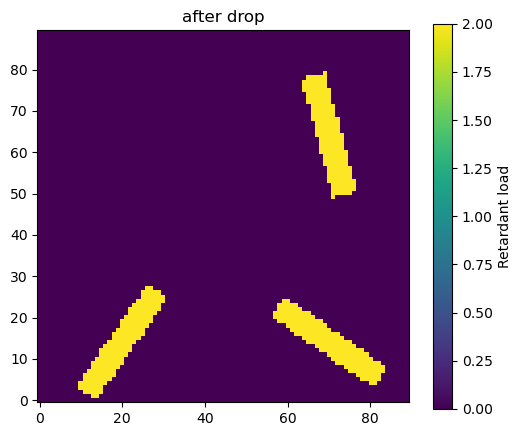

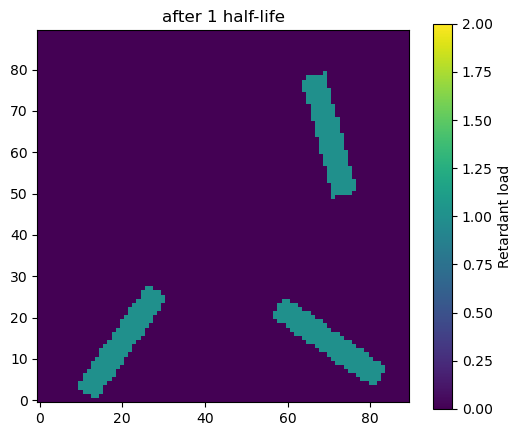

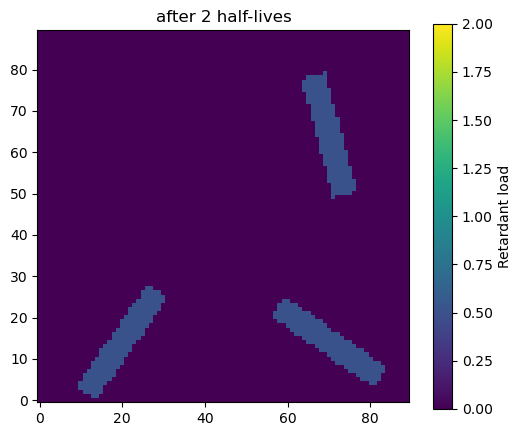

In [6]:
# Three drone parameters: (x0, y0, phi)
# Roughly bracket the active front with different headings
demo_drone_params = np.array([
    (ignition_center[0] + 25, ignition_center[1] + 25, np.deg2rad(15)),
    (ignition_center[0] - 25, ignition_center[1] - 25, np.deg2rad(-35)),
    (ignition_center[0] + 25, ignition_center[1] - 25, np.deg2rad(55)),
], dtype=float)

state_with_drop = finsler.simulate_from_firestate(
    init_state,
    T=eval_horizon_s,
    drone_params=demo_drone_params,
)

plot_firestate(state_with_drop, kind="affected", title="With-drop affected (same horizon)")
plot_firestate(state_with_drop, kind="retardant", title="With-drop retardant at evaluation time (after decay)")

# Visualise decay explicitly by querying the firestate at multiple absolute times.
t_abs0 = drop_time_s
t_abs1 = drop_time_s + retardant_half_life_s
t_abs2 = drop_time_s + 2 * retardant_half_life_s

# Re-run from ignition to ensure we view the drop starting at drop time
_ = finsler.simulate_from_ignition(T=drop_time_s, center=ignition_center, radius_km=ignition_radius_km)
# apply drop starting at t=drop_time_s
finsler.reset_retardant()
finsler._start_time_s = drop_time_s
finsler._retardant_t0_s = drop_time_s
finsler.apply_retardant_cartesian(demo_drone_params)
finsler.init_state(center=ignition_center, radius_km=ignition_radius_km)

st0 = finsler.firestate_at_time(t_abs0)
st1 = finsler.firestate_at_time(t_abs1)
st2 = finsler.firestate_at_time(t_abs2)

vmax = st0.retardant.max()
for state, title in [(st0, "after drop"), (st1, "after 1 half-life"), (st2, "after 2 half-lives")]:
    r = state.retardant[0]
    plt.figure(figsize=(6,5))
    plt.imshow(r.T, origin="lower", aspect="equal", vmin=0.0, vmax=vmax)
    plt.colorbar(label="Retardant load")
    plt.title(title)
    plt.show()



## 5. Fire boundary extraction in deterministic Finsler

In deterministic Finsler, the boundary is an **isochrone** (front) at a given time. `p_boundary` is just a threshold used by the boundary-extraction utility; for binary fields it can be fixed to `0.5`.

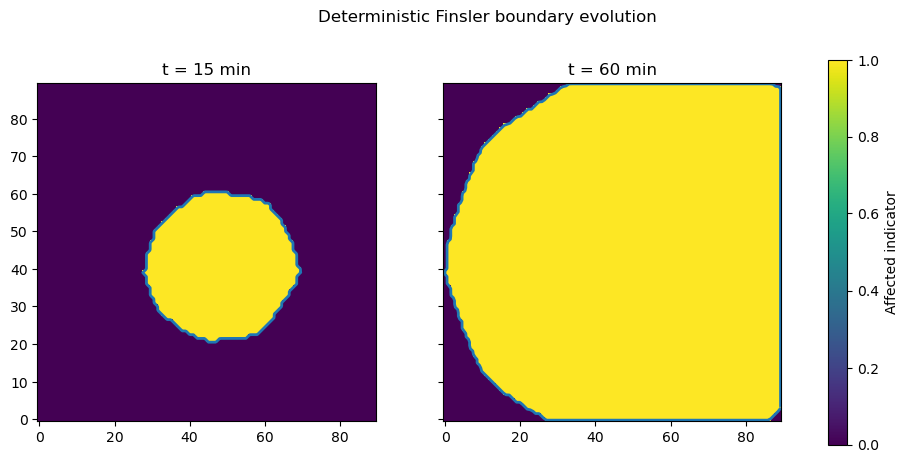

In [7]:
boundary_K = 360
p_boundary = 0.5  # threshold (not a probability in the deterministic model)

b_init = finsler.extract_fire_boundary(init_state, K=boundary_K, p_boundary=p_boundary, field="affected")
b_final = finsler.extract_fire_boundary(state_no_drop, K=boundary_K, p_boundary=p_boundary, field="affected")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for ax, st, bd, label in [
    (axes[0], init_state, b_init, f"t = {drop_time_s/60:.0f} min"),
    (axes[1], state_no_drop, b_final, f"t = {(drop_time_s+eval_horizon_s)/60:.0f} min"),
]:
    field = ((st.burning[0] > 0.5) | (st.burned[0] > 0.5)).astype(float)
    im = ax.imshow(field.T, origin="lower", aspect="equal")
    ax.plot(bd.xy[:, 0], bd.xy[:, 1], linewidth=2)
    ax.set_title(label)
plt.colorbar(im, ax=axes.ravel().tolist(), label="Affected indicator")
plt.suptitle("Deterministic Finsler boundary evolution")
plt.show()


## 6. Search domain (between boundaries)

We optimise only over a band between the boundary at drop time and at the evaluation horizon.

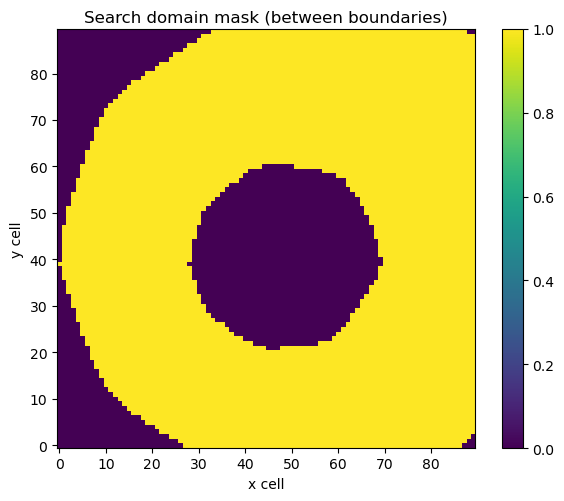

Valid search cells: 5976


In [8]:
search_mask = finsler.generate_search_domain(
    T=eval_horizon_s,
    init_firestate=init_state,
    p_boundary=0.5,
    K=300,
    boundary_field="affected",
)

plot_field(search_mask.astype(float), title="Search domain mask (between boundaries)")
xs_idx, ys_idx = np.where(search_mask)
coords = np.stack([xs_idx.astype(float), ys_idx.astype(float)], axis=1)
print("Valid search cells:", coords.shape[0])


## 7. Bayesian Optimisation (deterministic)

We minimise a deterministic objective:
- simulate Finsler to evaluation horizon with a candidate drop
- compute value-weighted burned area

Because the model is deterministic, the objective is deterministic (no Monte Carlo averaging).

In [9]:
from scipy.spatial import cKDTree
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel

class SearchGridProjector:
    def __init__(self, mask: np.ndarray, coords: np.ndarray):
        self.mask = np.asarray(mask, dtype=bool)
        self.coords = np.asarray(coords, dtype=float)
        if self.coords.size == 0:
            raise ValueError("Empty search domain.")
        order = np.lexsort((self.coords[:, 1], self.coords[:, 0]))
        self.coords = self.coords[order]
        self.tree = cKDTree(self.coords)
        self.shape = self.mask.shape

    def snap(self, x: float, y: float) -> np.ndarray:
        _, idx = self.tree.query([x, y], k=1)
        return self.coords[idx]

projector = SearchGridProjector(search_mask, coords)
nxg, nyg = projector.shape

def decode_theta(theta: np.ndarray, n_drones: int = 1) -> np.ndarray:
    """theta in [0,1]^(3*n_drones) -> (D,3) with (x_cell, y_cell, phi_rad)."""
    theta = np.asarray(theta, dtype=float).reshape(-1)
    params = []
    for d in range(n_drones):
        tx, ty, tphi = theta[3*d + 0], theta[3*d + 1], theta[3*d + 2]
        x_cont = tx * (nxg - 1)
        y_cont = ty * (nyg - 1)
        xg, yg = projector.snap(x_cont, y_cont)
        phi = tphi * (2.0 * np.pi)
        params.append((xg, yg, phi))
    params = np.array(params, dtype=float)
    # stable ordering
    order = np.lexsort((params[:, 2], params[:, 1], params[:, 0]))
    return params[order]

def theta_to_features(theta: np.ndarray, n_drones: int = 1) -> np.ndarray:
    p = decode_theta(theta, n_drones=n_drones)
    x = p[:, 0] / max(nxg - 1, 1)
    y = p[:, 1] / max(nyg - 1, 1)
    phi = p[:, 2]
    feats = np.stack([x, y, np.sin(phi), np.cos(phi)], axis=1)
    return feats.reshape(-1)

def objective(theta: np.ndarray, n_drones: int = 1) -> float:
    drone_params = decode_theta(theta, n_drones=n_drones)
    st = finsler.simulate_from_firestate(init_state, T=eval_horizon_s, drone_params=drone_params)
    burned = (st.burned[0] > 0.5).astype(float)
    dx = env.domain_km / env.grid_size[0]
    return float(np.sum(burned * env.value) * dx * dx)

def expected_improvement(Xcand, gp, y_best, xi=0.01):
    mu, sigma = gp.predict(Xcand, return_std=True)
    sigma = np.clip(sigma, 1e-9, None)
    imp = y_best - mu - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma <= 0.0] = 0.0
    return ei

# BO configuration
rng = np.random.default_rng(1234)
n_drones = 3
dim = 3 * n_drones


Init best objective: 9.10217492784441
Iter 01: y_next=9.5518  best=9.1022


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 03: y_next=9.2779  best=9.1022


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 06: y_next=9.5956  best=9.1022


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 09: y_next=9.2643  best=9.1022


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 12: y_next=9.0236  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 15: y_next=9.4909  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 18: y_next=9.3701  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 21: y_next=9.5505  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 24: y_next=9.3329  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 27: y_next=9.0483  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 30: y_next=9.2568  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 33: y_next=9.6347  best=9.0236
Iter 36: y_next=9.4931  best=9.0236
Iter 39: y_next=9.4061  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 42: y_next=9.5399  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 45: y_next=9.2791  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 48: y_next=9.0303  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 51: y_next=9.5785  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 54: y_next=9.4688  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 57: y_next=9.3292  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 60: y_next=9.4854  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 63: y_next=9.6326  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 66: y_next=9.5350  best=9.0236


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 69: y_next=8.7155  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 72: y_next=9.0955  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 75: y_next=9.5797  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 78: y_next=9.4906  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 81: y_next=9.2046  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 84: y_next=9.5357  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 87: y_next=9.3175  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 90: y_next=9.2462  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 93: y_next=9.5477  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 96: y_next=9.5551  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iter 99: y_next=9.5214  best=8.7155


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



Best objective: 8.715474608507222
Best (x,y,phi): [[31.         56.          5.06668982]
 [34.         54.          2.66141973]
 [49.         66.          2.58811134]]


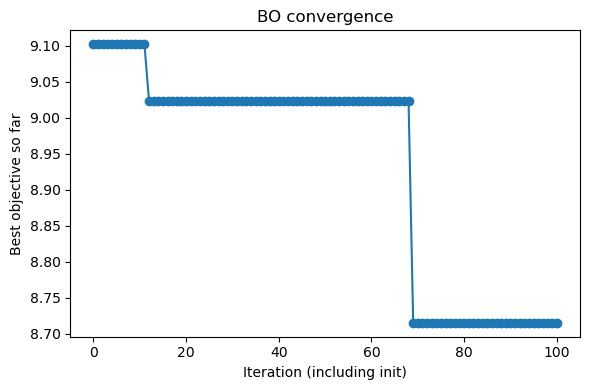

In [10]:
# Initial random evaluations
n_init = 8
X_theta = rng.random((n_init, dim))
y = np.array([objective(th, n_drones=n_drones) for th in X_theta], dtype=float)
X = np.vstack([theta_to_features(th, n_drones=n_drones) for th in X_theta])

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e-2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=2, random_state=0)

print("Init best objective:", float(np.min(y)))

# BO iterations
n_iters = 100
n_candidates = 3000
xi = 0.01

history_best = [float(np.min(y))]

for it in range(1, n_iters + 1):
    gp.fit(X, y)

    cand_theta = rng.random((n_candidates, dim))
    Xcand = np.vstack([theta_to_features(th, n_drones=n_drones) for th in cand_theta])

    y_best = float(np.min(y))
    ei = expected_improvement(Xcand, gp, y_best=y_best, xi=xi)
    best_idx = int(np.argmax(ei))

    theta_next = cand_theta[best_idx]
    y_next = float(objective(theta_next, n_drones=n_drones))

    X_theta = np.vstack([X_theta, theta_next])
    y = np.append(y, y_next)
    X = np.vstack([X, theta_to_features(theta_next, n_drones=n_drones)])

    history_best.append(float(np.min(y)))
    if it % 3 == 0 or it == 1:
        print(f"Iter {it:02d}: y_next={y_next:.4f}  best={float(np.min(y)):.4f}")

best_i = int(np.argmin(y))
best_theta = X_theta[best_i]
best_params = decode_theta(best_theta, n_drones=n_drones)
best_value = float(y[best_i])

print("\nBest objective:", best_value)
print("Best (x,y,phi):", best_params)

plt.figure(figsize=(6,4))
plt.plot(history_best, marker="o")
plt.xlabel("Iteration (including init)")
plt.ylabel("Best objective so far")
plt.title("BO convergence")
plt.tight_layout()
plt.show()


## 8. Visualise the best solution

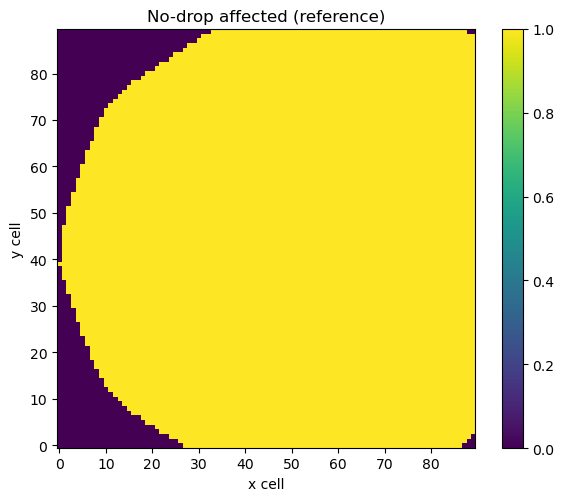

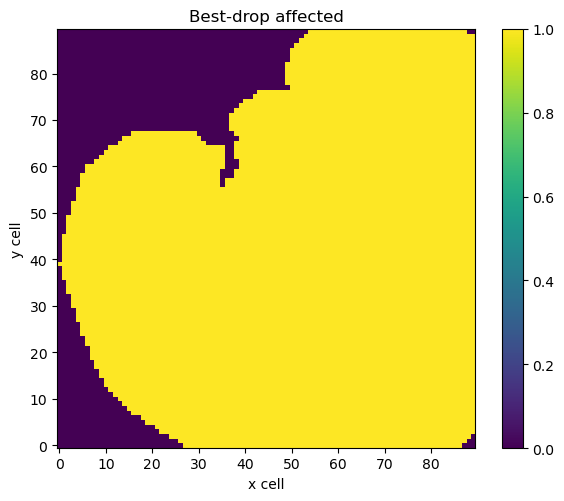

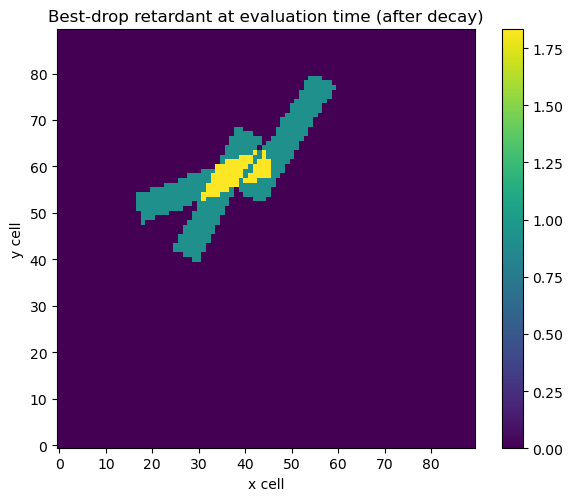

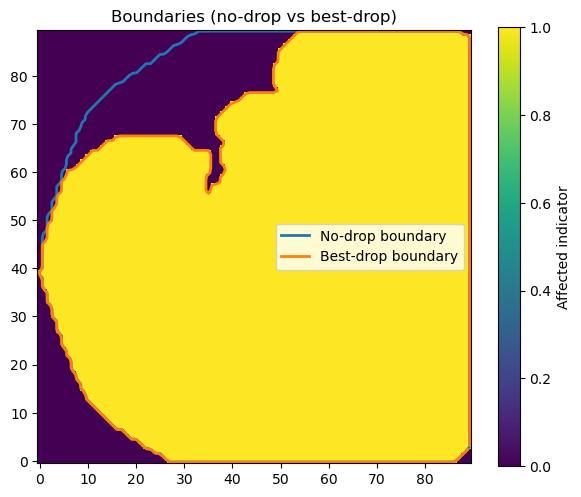

In [12]:
best_state = finsler.simulate_from_firestate(init_state, T=eval_horizon_s, drone_params=best_params)

plot_firestate(state_no_drop, kind="affected", title="No-drop affected (reference)")
plot_firestate(best_state, kind="affected", title="Best-drop affected")
plot_firestate(best_state, kind="retardant", title="Best-drop retardant at evaluation time (after decay)")

# Overlay boundaries for comparison
b0 = finsler.extract_fire_boundary(state_no_drop, K=360, p_boundary=0.5, field="affected")
b1 = finsler.extract_fire_boundary(best_state, K=360, p_boundary=0.5, field="affected")

plt.figure(figsize=(6,5))
field = ((best_state.burning[0] > 0.5) | (best_state.burned[0] > 0.5)).astype(float)
im = plt.imshow(field.T, origin="lower", aspect="equal")
plt.plot(b0.xy[:,0], b0.xy[:,1], linewidth=2, label="No-drop boundary")
plt.plot(b1.xy[:,0], b1.xy[:,1], linewidth=2, label="Best-drop boundary")
plt.legend()
plt.colorbar(im, label="Affected indicator")
plt.title("Boundaries (no-drop vs best-drop)")
plt.tight_layout()
plt.show()
